# 1️⃣ Random Forest Classifier for Multiclass Diabetes Prediction

Random Forest is used as a baseline ensemble model for multiclass diabetes classification.  
It handles complex relationships between features and provides robust predictions even on imbalanced data

In [1]:
# ----------------------------
# Preprocessing Notebook
# ----------------------------
%run ./Preprocessing.ipynb

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE


Preprocessed data saved as joblib files!


## 1.1️⃣ Target and Features

Selected important clinical features for predicting diabetes:

- `HbA1c`, `BMI`, `AGE`, `Urea`, `Chol`, `VLDL`, `TG`, `Cr`, `LDL`  
Target variable: `Class` (0=Non-diabetic, 1=Pre-diabetic, 2=Diabetic)


In [2]:
y = df["Class"]
selected_features = ['HbA1c', 'BMI', 'AGE', 'Urea', 'Chol', 'VLDL', 'TG', 'Cr', 'LDL']
X = df[selected_features]


## 1.2️⃣ Train/Test Split

- **Test size:** 20% of the dataset  
- **Stratified split** ensures all classes are proportionally represented in train and test sets


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


## 1.3️⃣ Handle Class Imbalance with SMOTE (Optional)

- SMOTE generates synthetic samples for minority classes  
- Ensures model is not biased toward majority class


In [4]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

## 1.4️⃣ Train Random Forest Classifier

- **n_estimators:** 200 trees  
- **class_weight='balanced':** adjusts weights inversely proportional to class frequencies


In [5]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)
rf_model.fit(X_train_res, y_train_res)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

## 1.5️⃣ Predict on Test Set & Evaluate

- Metrics: Accuracy, Classification Report  
- Visual: Confusion Matrix


Accuracy: 0.9811320754716981

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      1.00      1.00         8
           2       1.00      0.96      0.98        26

    accuracy                           0.98        53
   macro avg       0.98      0.99      0.98        53
weighted avg       0.98      0.98      0.98        53



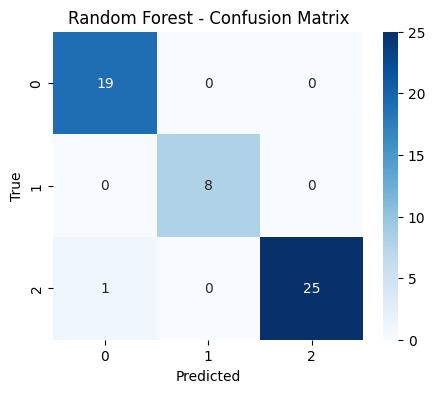

In [6]:
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## 1.6️⃣ Hyperparameter Tuning for Random Forest

- Uses **RandomizedSearchCV** to find the best combination of hyperparameters  
- Optimizes **F1_macro** for multiclass performance


In [7]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

rf = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': np.arange(100, 500, 50),
    'max_depth': np.arange(3, 20, 1),
    'min_samples_split': np.arange(2, 10, 1),
    'min_samples_leaf': np.arange(1, 5, 1),
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', None]
}

random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_macro',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

random_search_rf.fit(X_train_res, y_train_res)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None],
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': array([1, 2, 3, 4]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450])},
                   random_state=42, scoring='f1_macro', verbose=2)

## 1.7️⃣ Best Parameters & Test Evaluation

- `best_params_` → Optimal combination of parameters  
- `best_score_` → Cross-validated F1_macro score on training data

In [8]:
print("Best Hyperparameters:", random_search_rf.best_params_)
print("Best F1_macro Score:", random_search_rf.best_score_)

best_rf = random_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

print("Test Accuracy after Hyperparameter Tuning:", accuracy_score(y_test, y_pred_best_rf))
print("\nClassification Report after Hyperparameter Tuning:\n",
      classification_report(y_test, y_pred_best_rf))

Best Hyperparameters: {'n_estimators': np.int64(400), 'min_samples_split': np.int64(3), 'min_samples_leaf': np.int64(1), 'max_features': 'sqrt', 'max_depth': np.int64(10), 'class_weight': 'balanced'}
Best F1_macro Score: 0.9837076292400649
Test Accuracy after Hyperparameter Tuning: 0.9811320754716981

Classification Report after Hyperparameter Tuning:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      1.00      1.00         8
           2       1.00      0.96      0.98        26

    accuracy                           0.98        53
   macro avg       0.98      0.99      0.98        53
weighted avg       0.98      0.98      0.98        53



## 1.8️⃣ Key Insights

- Hyperparameter tuning improved **generalization** on test data  
- Random Forest handles **imbalanced multiclass problems** effectively with `class_weight='balanced'` and SMOTE  
- Confusion matrix shows **strong predictions** for all classes  
- Can be compared with **Gradient Boosting**, which may offer slightly better F1_macro in this dataset